In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pept import LineData, Pipeline, PointData
from pept.tracking import Stack, HDBSCAN, Cutpoints, SplitLabels, Centroids, Condition
from scipy.interpolate import interp1d
from skopt import gp_minimize
from skopt.space import Real, Integer
import sys
sys.path.append("/home/rayhaan/randomWalk_V3/Scripts/")
from interpolateTime import interpolateUnique
from tqdm import tqdm
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
%matplotlib widget

In [2]:
def errorCalculation(truePath: PointData, trackedPath: PointData) -> np.float64:
    fx = interp1d(truePath['t'], truePath['x'], fill_value = "extrapolate")
    fy = interp1d(truePath['t'], truePath['y'], fill_value = "extrapolate")
    fz = interp1d(truePath['t'], truePath['z'], fill_value = "extrapolate")

    xInterp = fx(trackedPath['t'])
    yInterp = fy(trackedPath['t'])
    zInterp = fz(trackedPath['t'])

    errorX = np.sum(np.abs(xInterp - trackedPath['x']))/len(xInterp)
    errorY = np.sum(np.abs(yInterp - trackedPath['y']))/len(xInterp)
    errorZ = np.sum(np.abs(zInterp - trackedPath['z']))/len(xInterp)

    combinedError = np.sqrt(errorX**2 + errorY**2 + errorZ**2)

    return combinedError

In [3]:
def loadTruePath(path: str) -> PointData:
    data = np.loadtxt(path, skiprows = 3)
    points = np.array([data[:, 0], data[:, 5], data[:, 6], data[:, 7]]).T
    pData = PointData(points)
    return pData

def loadData(path: str) -> LineData:
    lines = np.load(path)
    rawLines = np.array([lines[:, 6], lines[:, 0], lines[:, 1], lines[:, 2], lines[:, 3], lines[:, 4], lines[:, 5]]).T
    lData = LineData(rawLines)
    return lData

In [4]:
trueData = loadTruePath(path = "/home/rayhaan/randomWalk_V3/GATE_Generation/Sigma_2.0mm_Tau_0.08ms_1.2ms_placements/RW3_TS_0.08ms_SS_2.00mm.placements")
lors = loadData(path = "/home/rayhaan/randomWalk_V3/GATE_Generation/Sigma_2.0mm_Tau_0.08ms_1.2ms_NPY/RW3_TS_0.08ms_SS_2.00mm.npy")

In [5]:
times = lors['t']
newTime = interpolateUnique(msTime = times)
lors_2 = LineData(np.c_[newTime, lors.lines[:, 1:7]])

In [16]:
MLPipe = Pipeline([
            Stack(sample_size = 40, overlap = 0),
            Cutpoints(max_distance = 3.0),
            HDBSCAN(true_fraction = 0.1),
            SplitLabels() + Centroids(),

            Stack(sample_size = 5, overlap = 4), 
            HDBSCAN(true_fraction = 0.6),
            SplitLabels() + Centroids(),
            Stack()
        ])

In [17]:
locTest = MLPipe.fit(lors_2)
print("The location rate is {} Hz".format(len(locTest.points)/0.5))

Batch 2 / 2 :: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6243/6243 [00:06<00:00, 1000.92it/s]



Processed samples in 10.559792518615723 s

The location rate is 11928.0 Hz


In [53]:
# filter2 = Condition("t >= 0.0, t <= 0.5") + Stack()
# locTest2 = filter2.fit(locTest)a

In [54]:
# np.save("/home/rayhaan/randomWalk_V3/Plots/truePath", arr = trueData.points)

In [55]:
# plt.close("all")
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (7, 5), sharex = "col")

# fig.suptitle("TS_0.4ms_Lambda_2.0mm_L_245.954kHz")
# ax1.scatter(locTest2['t'], locTest2['x'], s = 0.1, color = 'k', zorder = 1, label = "ML_Track")
# ax1.plot(trueData['t'], trueData['x'], lw = 1, color = 'r', zorder = 0, label = "True_Path")

# ax2.scatter(locTest2['t'], locTest2['y'], s = 0.1, color = 'k', zorder = 1, label = "ML_Track")
# ax2.plot(trueData['t'], trueData['y'], lw = 1, color = 'r', zorder = 0, label = "True_Path")

# ax3.scatter(locTest2['t'], locTest2['z'], s = 0.1, color = 'k', zorder = 1, label = "ML_Track")
# ax3.plot(trueData['t'], trueData['z'], lw = 1, color = 'r', zorder = 0, label = "True_Path")

# ax1.legend()
# ax2.legend()
# ax3.legend()

# ax3.set_xlabel("t (s)")

# ax1.set_ylabel("X (mm)")
# ax2.set_ylabel("Y (mm)")
# ax3.set_ylabel("Z (mm)")

# fig.tight_layout()
# fig.savefig("/home/rayhaan/randomWalk_V3/Plots/Test_Extreme_OL1.png", dpi = 300)




In [22]:
def optAllML(lowerLocRate, upperLocRate, Data, truePath):

    # out = []

# for i in tqdm(range(len(UsedSampleSizes)-1)):
    def ObjectiveML(x):
        MLPipe = Pipeline([
            Stack(sample_size = x[0], overlap = 0),
            Cutpoints(max_distance = 3.0),
            HDBSCAN(true_fraction = x[1]),
            SplitLabels() + Centroids(),

            Stack(sample_size = 5, overlap = 4), 
            HDBSCAN(true_fraction = x[2]),
            SplitLabels() + Centroids(),
            Stack()
        ])

        locs = MLPipe.fit(Data, verbose = True)

        locRate = len(locs.points)/0.5

        error = errorCalculation(truePath = truePath, trackedPath = locs)

        if (locRate >= lowerLocRate) and (locRate <= upperLocRate):
            error = error
        else:
            error = 10000 + error

        print("The error is: {} mm, the location rate is: {} kHz".format(error, locRate))

        return error

    space = [   Integer(25, 35, name = 'SS1'),
                # Real(1.0, 3.0, name = 'MD'),
                Real(0.1, 0.6, name = 'TF1'),
                Real(0.55, 0.65, name = 'TF2'),
                    ]

    res = gp_minimize(ObjectiveML, space, n_calls = 20, verbose = True, random_state = 657333)

    out1 = [res.fun, res.x[0], res.x[1], res.x[2]]

    return out1

In [23]:
1/(0.08e-3)

12499.999999999998

In [24]:
lowerLocRate = 11000
upperLocRate = 14000

In [25]:
optVals = optAllML(lowerLocRate = lowerLocRate, upperLocRate = upperLocRate, Data = lors_2, truePath = trueData)

Iteration No: 1 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6630/6630 [00:07<00:00, 942.51it/s]



Processed samples in 13.480313062667847 s

The error is: 29.298642393339417 mm, the location rate is: 12766.0 kHz
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 13.4855
Function value obtained: 29.2986
Current minimum: 29.2986
Iteration No: 2 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5776/5776 [00:06<00:00, 959.50it/s]



Processed samples in 12.980381488800049 s

The error is: 29.342364841777602 mm, the location rate is: 11080.0 kHz
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 12.9851
Function value obtained: 29.3424
Current minimum: 29.2986
Iteration No: 3 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10525/10525 [00:11<00:00, 934.23it/s]



Processed samples in 17.63435459136963 s

The error is: 20088.453245154924 mm, the location rate is: 2416.0 kHz
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 17.6368
Function value obtained: 20088.4532
Current minimum: 29.2986
Iteration No: 4 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12437/12437 [00:13<00:00, 929.76it/s]



Processed samples in 17.481810808181763 s

The error is: 19798.24906772514 mm, the location rate is: 2788.0 kHz
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 17.4842
Function value obtained: 19798.2491
Current minimum: 29.2986
Iteration No: 5 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4311/4311 [00:04<00:00, 962.13it/s]



Processed samples in 9.446417570114136 s

The error is: 21579.002095828757 mm, the location rate is: 922.0 kHz
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 9.4489
Function value obtained: 21579.0021
Current minimum: 29.2986
Iteration No: 6 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9586/9586 [00:10<00:00, 932.68it/s]



Processed samples in 16.76645040512085 s

The error is: 20506.782759635622 mm, the location rate is: 2010.0 kHz
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 16.7688
Function value obtained: 20506.7828
Current minimum: 29.2986
Iteration No: 7 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5277/5277 [00:05<00:00, 941.53it/s]



Processed samples in 11.718341827392578 s

The error is: 12326.757068596386 mm, the location rate is: 10200.0 kHz
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 11.7220
Function value obtained: 12326.7571
Current minimum: 29.2986
Iteration No: 8 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4432/4432 [00:04<00:00, 966.09it/s]



Processed samples in 9.895391941070557 s

The error is: 21627.09608878907 mm, the location rate is: 884.0 kHz
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 9.8981
Function value obtained: 21627.0961
Current minimum: 29.2986
Iteration No: 9 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4304/4304 [00:04<00:00, 956.28it/s]



Processed samples in 9.453761577606201 s

The error is: 21580.94247633691 mm, the location rate is: 920.0 kHz
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 9.4568
Function value obtained: 21580.9425
Current minimum: 29.2986
Iteration No: 10 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4424/4424 [00:04<00:00, 963.34it/s]



Processed samples in 9.760216236114502 s

The error is: 21638.71300074475 mm, the location rate is: 886.0 kHz
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 10.1321
Function value obtained: 21638.7130
Current minimum: 29.2986
Iteration No: 11 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5559/5559 [00:05<00:00, 970.36it/s]



Processed samples in 11.826273441314697 s

The error is: 11818.343327675386 mm, the location rate is: 10710.0 kHz
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 12.2375
Function value obtained: 11818.3433
Current minimum: 29.2986
Iteration No: 12 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5761/5761 [00:06<00:00, 954.17it/s]



Processed samples in 12.888166666030884 s

The error is: 29.6472562347079 mm, the location rate is: 11124.0 kHz
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 13.2530
Function value obtained: 29.6473
Current minimum: 29.2986
Iteration No: 13 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6641/6641 [00:06<00:00, 959.68it/s]



Processed samples in 13.467079162597656 s

The error is: 23.87595728557128 mm, the location rate is: 12814.0 kHz
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 13.7494
Function value obtained: 23.8760
Current minimum: 23.8760
Iteration No: 14 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6659/6659 [00:06<00:00, 960.87it/s]



Processed samples in 13.529101610183716 s

The error is: 24.56541117376781 mm, the location rate is: 12868.0 kHz
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 13.7992
Function value obtained: 24.5654
Current minimum: 23.8760
Iteration No: 15 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6641/6641 [00:06<00:00, 951.83it/s]



Processed samples in 13.50591516494751 s

The error is: 27.30428020611221 mm, the location rate is: 12782.0 kHz
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 13.7420
Function value obtained: 27.3043
Current minimum: 23.8760
Iteration No: 16 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5768/5768 [00:05<00:00, 962.35it/s]



Processed samples in 12.85605001449585 s

The error is: 28.36564997891992 mm, the location rate is: 11122.0 kHz
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 13.0930
Function value obtained: 28.3656
Current minimum: 23.8760
Iteration No: 17 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6990/6990 [00:07<00:00, 930.41it/s]



Processed samples in 14.186939239501953 s

The error is: 21086.863719991787 mm, the location rate is: 1456.0 kHz
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 14.5998
Function value obtained: 21086.8637
Current minimum: 23.8760
Iteration No: 18 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6723/6723 [00:07<00:00, 933.67it/s]



Processed samples in 13.379591703414917 s

The error is: 22.11611736505079 mm, the location rate is: 12890.0 kHz
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 13.7359
Function value obtained: 22.1161
Current minimum: 22.1161
Iteration No: 19 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6766/6766 [00:07<00:00, 950.39it/s]



Processed samples in 13.403918743133545 s

The error is: 22.142704057727087 mm, the location rate is: 12966.0 kHz
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 13.7408
Function value obtained: 22.1427
Current minimum: 22.1161
Iteration No: 20 started. Searching for the next optimal point.


Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6710/6710 [00:07<00:00, 949.02it/s]



Processed samples in 13.77169418334961 s

The error is: 22.4360379787708 mm, the location rate is: 12876.0 kHz
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 14.4011
Function value obtained: 22.4360
Current minimum: 22.1161


In [26]:
optVals

[22.11611736505079, 27, 0.19154125756473556, 0.611677887676929]

In [27]:
MLPipeOpt = Pipeline([
            Stack(sample_size = optVals[1], overlap = 0),
            Cutpoints(max_distance = 3.0),
            HDBSCAN(true_fraction = optVals[2]),
            SplitLabels() + Centroids(),

            Stack(sample_size = 5, overlap = 4), 
            HDBSCAN(true_fraction = optVals[3]),
            SplitLabels() + Centroids(),
            Stack()
        ])

In [28]:
optLocs = MLPipeOpt.fit(lors_2)
print("The location rate is {:.2f} Hz".format(len(optLocs.points)/0.5))

Batch 2 / 2 :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6714/6714 [00:07<00:00, 958.95it/s]



Processed samples in 13.61336088180542 s

The location rate is 12946.00 Hz


In [29]:
optLocs

pept.PointData (samples: 6714)
------------------------------
sample_size = [1 1 1 ... 1 1 1]
overlap = None
points = 
  (rows: 6473, columns: 4)
  [[ 1.89556281e-04  7.06104100e+00  7.31948565e+00  2.04817617e+00]
   [ 2.63685880e-04  6.04426838e+00  7.68379173e+00  8.52390183e-01]
   ...
   [ 1.11208643e+00 -8.30263530e+01  1.03805481e+02  2.84128294e+01]
   [ 1.25013376e+00 -8.18893697e+01  1.03040837e+02  2.72781170e+01]]
columns = ['t', 'x', 'y', 'z']
attrs = {}

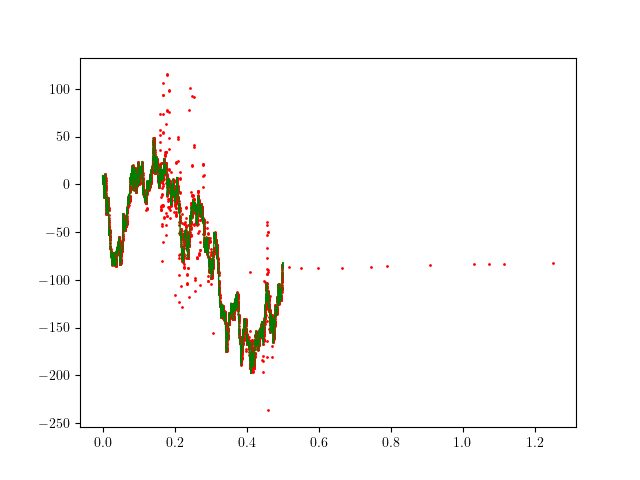

In [30]:
plt.close("all")
fig, ax = plt.subplots(1, 1)

ax.scatter(optLocs['t'], optLocs['x'], color = 'r', s = 1)
ax.plot(trueData['t'], trueData['x'], color = 'g', lw = 1)

In [31]:
filter1 = Condition("t >= 0.0, t <= 0.5") + Stack()
filteredLocs = filter1.fit(optLocs)

Batch 1 / 1 :: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6714/6714 [00:06<00:00, 1078.67it/s]



Processed samples in 6.685084104537964 s



In [32]:
np.save("/home/rayhaan/randomWalk_V3/GATE_Generation/Sigma_2.0mm_Tau_0.08ms_1.2ms_tracks/RW3_TS_0.08ms_SS_2.00mm.npy", arr = filteredLocs.points)

In [33]:
uncertainty = errorCalculation(truePath = trueData, trackedPath = optLocs)

In [34]:
print("The uncertainty is {} mm".format(uncertainty))

The uncertainty is 24.25424404793173 mm
